# **Predicting Reservation Cancellations with PyTorch**

---

This notebook uses the Hotel Reservations Dataset provided by Ahsan Raza on Kaggle ([Available here](https://www.kaggle.com/datasets/ahsan81/hotel-reservations-classification-dataset)). 

The dataset consists of a ID feature `Booking_ID`, 17 features and a `booking_status` label to indicate if it was cancelled. 

**High level overview of data:**
* There are 36275 records in the dataset. 
* There are no missing records.
* There are no duplicated records.
* There are no overlapping records between the train and test set.
* There are equal number of legitimate and phishing URLs in the train set.

**Goal of notebook:**

This notebook serves as practice for utilizing PyTorch for deep learning, specifically training a binary classifier on tublar data. As such, the exploratory data analysis will be kept to a minimum.



In [171]:
!pip install captum --quiet

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [172]:
# import data manipulation libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

# import machine learning libraries
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve
from sklearn.manifold import TSNE
import torch
import captum

## Importing Data

---

The following is the data dictionary provided with the dataset.

>**Booking_ID**: unique identifier of each booking
>
>**no_of_adults**: Number of adults
>
>**no_of_children**: Number of Children
>
>**no_of_weekend_nights**: Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
>
>**no_of_week_nights**: Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel
>
>**type_of_meal_plan**: Type of meal plan booked by the customer
>
>**required_car_parking_space**: Does the customer require a car parking space? (0 - No, 1- Yes)
>
>**room_type_reserved**: Type of room reserved by the customer. The values are ciphered (encoded) by INN Hotels.
>
>**lead_time**: Number of days between the date of booking and the arrival date
>
>**arrival_year**: Year of arrival date
>
>**arrival_month**: Month of arrival date
>
>**arrival_date**: Date of the month
>
>**market_segment_type**: Market segment designation.
>
>**repeated_guest**: Is the customer a repeated guest? (0 - No, 1- Yes)
>
>**no_of_previous_cancellations**: Number of previous bookings that were canceled by the customer prior to the current booking
>
>**no_of_previous_bookings_not_canceled**: Number of previous bookings not canceled by the customer prior to the current booking
>
>**avg_price_per_room**: Average price per day of the reservation; prices of the rooms are dynamic. (in euros)
>
>**no_of_special_requests**: Total number of special requests made by the customer (e.g. high floor, view from the room, etc)
>
>**booking_status**: Flag indicating if the booking was canceled or not.


In [173]:
# import the train dataset
raw_df = pd.read_csv("/kaggle/input/hotel-reservations-classification-dataset/Hotel Reservations.csv")
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36275 entries, 0 to 36274
Data columns (total 19 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   Booking_ID                            36275 non-null  object 
 1   no_of_adults                          36275 non-null  int64  
 2   no_of_children                        36275 non-null  int64  
 3   no_of_weekend_nights                  36275 non-null  int64  
 4   no_of_week_nights                     36275 non-null  int64  
 5   type_of_meal_plan                     36275 non-null  object 
 6   required_car_parking_space            36275 non-null  int64  
 7   room_type_reserved                    36275 non-null  object 
 8   lead_time                             36275 non-null  int64  
 9   arrival_year                          36275 non-null  int64  
 10  arrival_month                         36275 non-null  int64  
 11  arrival_date   

In [174]:
# peek the train data
raw_df.head(5)

,Booking_ID,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,type_of_meal_plan,required_car_parking_space,room_type_reserved,lead_time,arrival_year,arrival_month,arrival_date,market_segment_type,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests,booking_status
0,INN00001,2,0,1,2,Meal Plan 1,0,Room_Type 1,224,2017,10,2,Offline,0,0,0,65.00,0,Not_Canceled
1,INN00002,2,0,2,3,Not Selected,0,Room_Type 1,5,2018,11,6,Online,0,0,0,106.68,1,Not_Canceled
2,INN00003,1,0,2,1,Meal Plan 1,0,Room_Type 1,1,2018,2,28,Online,0,0,0,60.00,0,Canceled
3,INN00004,2,0,0,2,Meal Plan 1,0,Room_Type 1,211,2018,5,20,Online,0,0,0,100.00,0,Canceled
4,INN00005,2,0,1,1,Not Selected,0,Room_Type 1,48,2018,4,11,Online,0,0,0,94.50,0,Canceled


## Data Quality Assurance

---

Quick check for issues with the data. Things to look out for are: (1) missing values, (2) duplicated values, (3) wrong values (i.e. negative number of adults, etc), and (4) class imbalance. 

The train-test split is also created at this stage to prevent as leakage from the test set.

In [175]:
# create the train-test split
df = raw_df.copy()
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['booking_status'])

In [176]:
# check for wrong values
df.describe()

,no_of_adults,no_of_children,no_of_weekend_nights,no_of_week_nights,required_car_parking_space,lead_time,arrival_year,arrival_month,arrival_date,repeated_guest,no_of_previous_cancellations,no_of_previous_bookings_not_canceled,avg_price_per_room,no_of_special_requests
count,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000,36275.000000
mean,1.844962,0.105279,0.810724,2.204300,0.030986,85.232557,2017.820427,7.423653,15.596995,0.025637,0.023349,0.153411,103.423539,0.619655
std,0.518715,0.402648,0.870644,1.410905,0.173281,85.930817,0.383836,3.069894,8.740447,0.158053,0.368331,1.754171,35.089424,0.786236
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2017.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,0.000000,17.000000,2018.000000,5.000000,8.000000,0.000000,0.000000,0.000000,80.300000,0.000000
50%,2.000000,0.000000,1.000000,2.000000,0.000000,57.000000,2018.000000,8.000000,16.000000,0.000000,0.000000,0.000000,99.450000,0.000000
75%,2.000000,0.000000,2.000000,3.000000,0.000000,126.000000,2018.000000,10.000000,23.000000,0.000000,0.000000,0.000000,120.000000,1.000000
max,4.000000,10.000000,7.000000,17.000000,1.000000,443.000000,2018.000000,12.000000,31.000000,1.000000,13.000000,58.000000,540.000000,5.000000


In [177]:
# check for missing data
num_missing = df.isna().sum(axis=0)
num_missing = num_missing[num_missing != 0]
print("Number of missing data:")
print("None" if num_missing.empty else num_missing)

Number of missing data:
None


In [178]:
# check for duplicated data
duplicates = df[df.duplicated(keep=False)]
print("Duplicated data:")
print("None" if duplicates.empty else duplicates)

Duplicated data:
None


In [179]:
# check target labels
unqiue_targets = sorted(list(df['booking_status'].unique()))
print("Target Labels:", ', '.join(unqiue_targets))

Target Labels: Canceled, Not_Canceled


Number of canceled bookings: 11885
Number of not canceled bookings: 24390


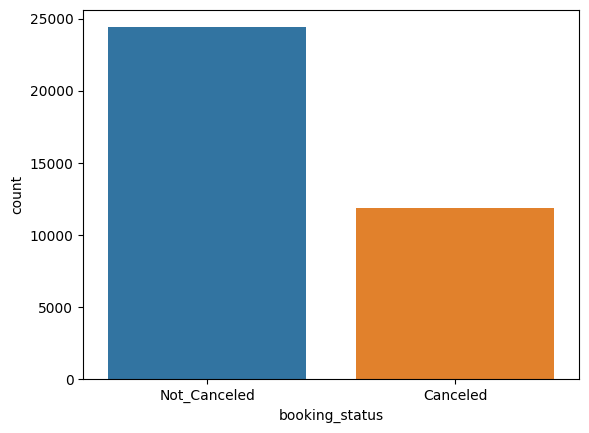

In [180]:
# check frequency of labels
count = df['booking_status'].value_counts()
sb.countplot(data=df, x='booking_status')

print(f"Number of canceled bookings:", count['Canceled'])
print(f"Number of not canceled bookings:", count['Not_Canceled'])

## Data Visualization

---

A quick visualization of the data. Normally, the main bulk of analysis would be at this stage. However, this notebook is for practicing PyTorch so only a quick visualization is done.

In [181]:
# split columns into integer and float
int_cols = []
float_cols = []
cat_cols = []
for col in train_df.columns:
    if train_df[col].dtype == np.int64:
        int_cols.append(col)
    elif train_df[col].dtype == np.float64:
        float_cols.append(col)
    else:
        cat_cols.append(col)
    
print("int64 columns:\n\t", '\n\t '.join([', '.join(int_cols[i: i + 5]) for i in range(0, len(int_cols), 5)]), '\n')
print("float64 columns:\n\t", '\n\t '.join([', '.join(float_cols[i: i + 5]) for i in range(0, len(float_cols), 5)]), '\n')
print("categorical columns:\n\t", '\n\t '.join([', '.join(cat_cols[i: i + 5]) for i in range(0, len(cat_cols), 5)]))

int64 columns:
	 no_of_adults, no_of_children, no_of_weekend_nights, no_of_week_nights, required_car_parking_space
	 lead_time, arrival_year, arrival_month, arrival_date, repeated_guest
	 no_of_previous_cancellations, no_of_previous_bookings_not_canceled, no_of_special_requests 

float64 columns:
	 avg_price_per_room 

categorical columns:
	 Booking_ID, type_of_meal_plan, room_type_reserved, market_segment_type, booking_status


In [182]:
int_cols = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights', 'no_of_week_nights', 'arrival_year', 'required_car_parking_space',
            'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled', 'no_of_special_requests', 'lead_time', 'repeated_guest']
float_cols = ['avg_price_per_room']
cat_cols = ['type_of_meal_plan', 'room_type_reserved', 'market_segment_type', 'arrival_month', 'arrival_date']

In [183]:
# define helper functions for visualization
def col_gen(cols: list[str], sep: int = 6):
    for i in range(0, len(cols), sep):
        yield cols[i: i + sep]

int_gen = col_gen(int_cols)
def generate_plots(data: pd.DataFrame, col: list[str]) -> plt.Figure:
    plt.figure(figsize=(5 * 2, 5 * max(1, len(col) // 2 + 1)))
    for i, c in enumerate(col):
        plt.subplot(max(1, len(col) // 2 + 1), 2, i + 1)
        plt.scatter(np.arange(len(data[c])), data[c], c=data['booking_status'].map({ "Not_Canceled": "green", "Canceled": "red" }))
        plt.xlabel(c)
    return plt.gcf()

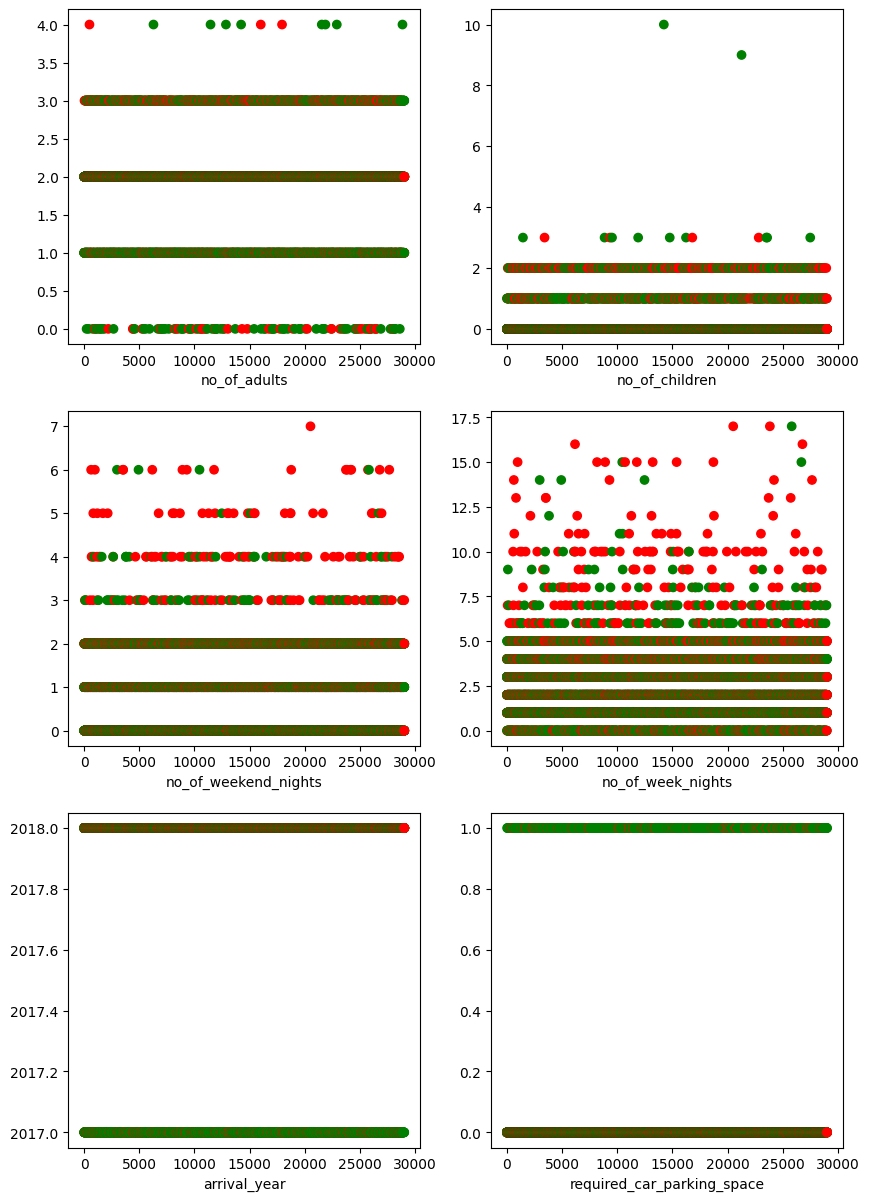

In [184]:
cols = next(int_gen)
_ = generate_plots(train_df, cols)

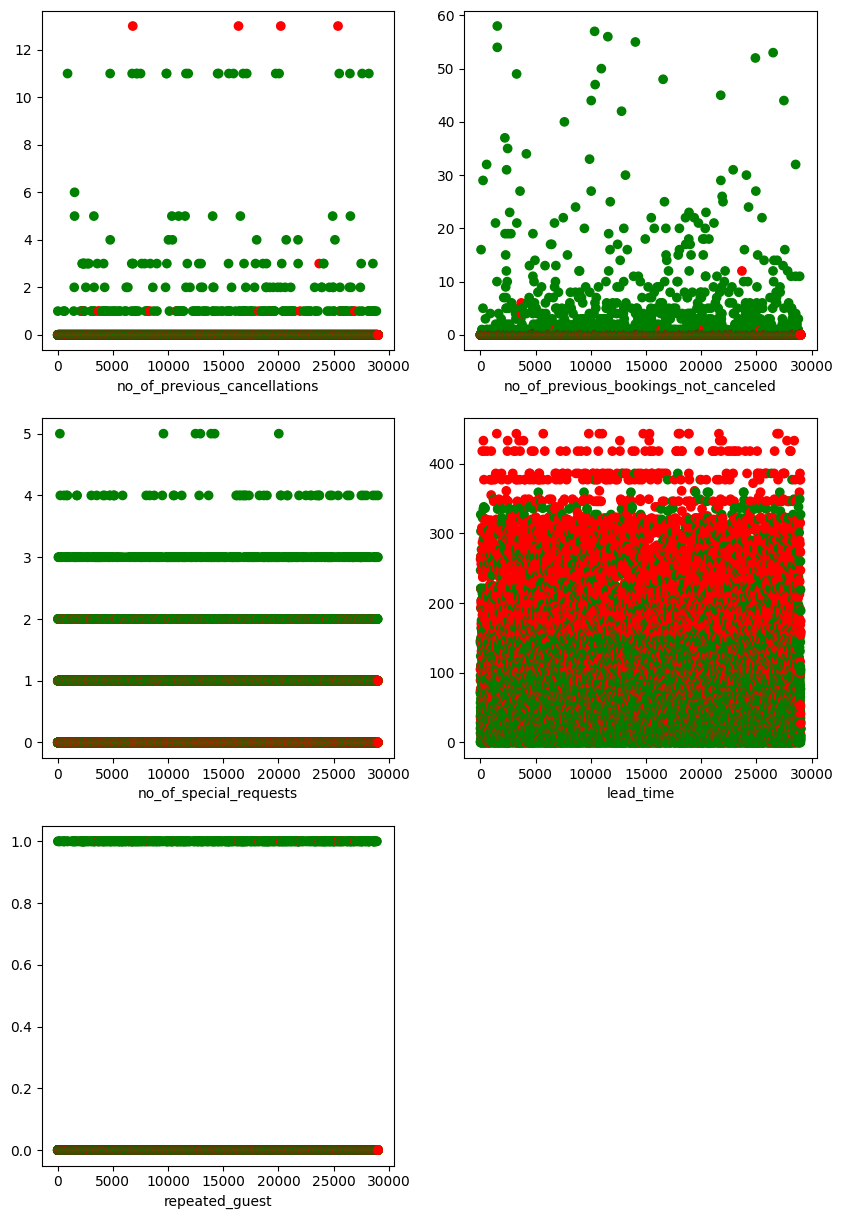

In [185]:
cols = next(int_gen)
_ = generate_plots(train_df, cols)

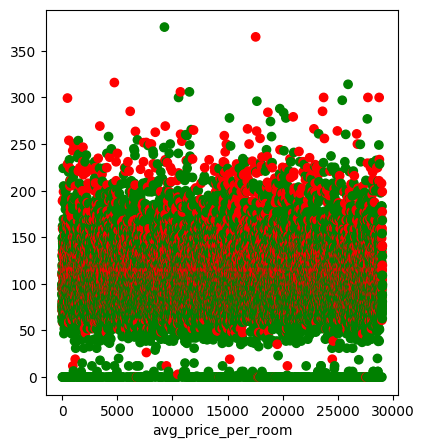

In [186]:
cols = float_cols
_ = generate_plots(train_df, cols)

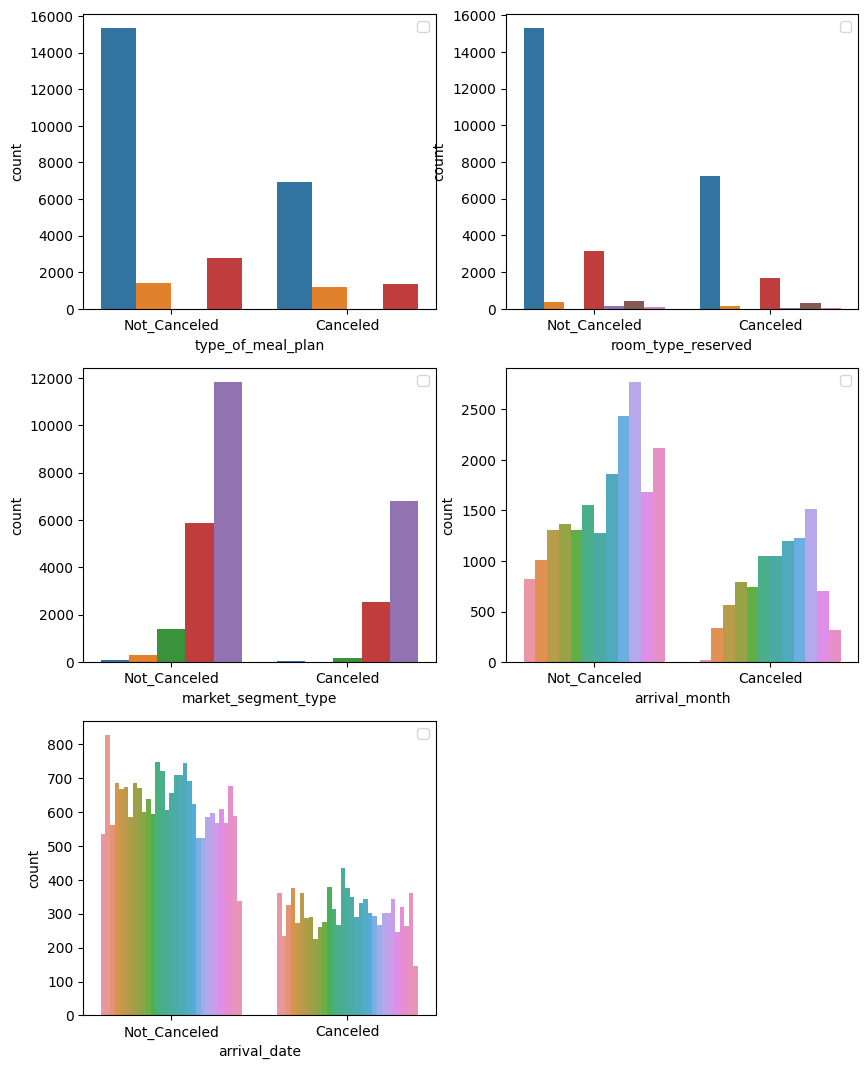

In [187]:
cols = cat_cols
plt.figure(figsize=(5 * 2, 5 * len(cols) // 2 + 1))
for i, c in enumerate(cols):
    plt.subplot(len(cols) // 2 + 1, 2, i + 1)
    sb.countplot(data=train_df.sort_values(c), x='booking_status', hue=c, ax=plt.gca())
    plt.legend([])
    plt.xlabel(c)

## Data Preparation

---

Based on the data visualization, I've decided to clip some of the values as there are too few records. 

Besides that, the numeric values will be scaled to [0, 1] for better performance and categorical values will be converted to indexes for use with embedding layers.

In [188]:
# clip numeric features
train_df['no_of_children'] = train_df['no_of_children'].apply(lambda x: min(5, x))
train_df['avg_price_per_room'] = train_df['avg_price_per_room'].apply(lambda x: min(300, x))
train_df['no_of_special_requests'] = train_df['no_of_special_requests'].apply(lambda x: min(4, x))
train_df['no_of_previous_cancellations'] = train_df['no_of_previous_cancellations'].apply(lambda x: min(1, x))

test_df['no_of_children'] = test_df['no_of_children'].apply(lambda x: min(5, x))
test_df['avg_price_per_room'] = test_df['avg_price_per_room'].apply(lambda x: min(300, x))
test_df['no_of_special_requests'] = test_df['no_of_special_requests'].apply(lambda x: min(4, x))
test_df['no_of_previous_cancellations'] = test_df['no_of_previous_cancellations'].apply(lambda x: min(1, x))

In [189]:
# scale features to [0,1]
maximum = train_df[int_cols + float_cols].max(axis=0)
minimum = train_df[int_cols + float_cols].min(axis=0)
train_df[int_cols + float_cols] = (train_df[int_cols + float_cols] - minimum.T) / (maximum.T - minimum.T) 
test_df[int_cols + float_cols] = (test_df[int_cols + float_cols] - minimum.T) / (maximum.T - minimum.T) 

In [190]:
# Convert categorical features to indexes
index_lookup = {}
for col in cat_cols + ['booking_status']:
    index = {x: i for i, x in enumerate(train_df[col].unique())}
    index_lookup[col] = index
    train_df[col] = train_df[col].map(index)
    test_df[col] = test_df[col].map(index)
for col in cat_cols + ['booking_status']:
    print(col, index_lookup[col], sep='\t')

type_of_meal_plan	{'Not Selected': 0, 'Meal Plan 1': 1, 'Meal Plan 2': 2, 'Meal Plan 3': 3}
room_type_reserved	{'Room_Type 1': 0, 'Room_Type 2': 1, 'Room_Type 4': 2, 'Room_Type 6': 3, 'Room_Type 7': 4, 'Room_Type 5': 5, 'Room_Type 3': 6}
market_segment_type	{'Online': 0, 'Offline': 1, 'Corporate': 2, 'Complementary': 3, 'Aviation': 4}
arrival_month	{8: 0, 6: 1, 4: 2, 10: 3, 11: 4, 3: 5, 9: 6, 2: 7, 5: 8, 1: 9, 12: 10, 7: 11}
arrival_date	{29: 0, 17: 1, 14: 2, 24: 3, 25: 4, 6: 5, 21: 6, 11: 7, 4: 8, 18: 9, 26: 10, 12: 11, 7: 12, 13: 13, 30: 14, 28: 15, 31: 16, 9: 17, 19: 18, 15: 19, 27: 20, 5: 21, 22: 22, 3: 23, 10: 24, 16: 25, 23: 26, 8: 27, 2: 28, 1: 29, 20: 30}
booking_status	{'Not_Canceled': 0, 'Canceled': 1}


The pandas dataframe will be converted to PyTorch Dataloaders to train the model.

In [191]:
# make a copy of dataframe
train = train_df.copy()

# split the dataframe
train_y = train['booking_status']
train_cat = train[cat_cols]
train_X = train.drop(['booking_status', 'Booking_ID'] + cat_cols, axis=1)


# convert to tensors
train_y = torch.from_numpy(train_y.to_numpy()).unsqueeze(1).type(torch.float32)
train_cat = torch.from_numpy(train_cat.to_numpy()).type(torch.int32)
train_X = torch.from_numpy(train_X.to_numpy()).type(torch.float32)

# make a copy of dataframe
test = test_df.copy()

# split the dataframe
test_y = test['booking_status']
test_cat = test[cat_cols]
test_X = test.drop(['booking_status', 'Booking_ID'] + cat_cols, axis=1)

# convert to tensors
test_y = torch.from_numpy(test_y.to_numpy()).unsqueeze(1).type(torch.float32)
test_cat = torch.from_numpy(test_cat.to_numpy()).type(torch.int32)
test_X = torch.from_numpy(test_X.to_numpy()).type(torch.float32)

print(f"Shape of train_X: {train_X.shape}")
print(f"Shape of train_cat: {train_cat.shape}")
print(f"Shape of train_y: {train_y.shape}")
print(f"Shape of test_X:  {test_X.shape}")
print(f"Shape of test_cat: {test_cat.shape}")
print(f"Shape of test_y:  {test_y.shape}")

Shape of train_X: torch.Size([29020, 12])
Shape of train_cat: torch.Size([29020, 5])
Shape of train_y: torch.Size([29020, 1])
Shape of test_X:  torch.Size([7255, 12])
Shape of test_cat: torch.Size([7255, 5])
Shape of test_y:  torch.Size([7255, 1])


In [192]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, X: torch.tensor, cat: torch.tensor, y: torch.tensor):
        super().__init__()
        
        self.X = X
        self.cat = cat
        self.y = y
        
    def __getitem__(self, i: int) -> tuple[torch.tensor]:
        return self.X[i], self.cat[i], self.y[i]

    def __len__(self) -> int:
        return len(self.X)

In [193]:
train_ds = CustomDataset(train_X, train_cat, train_y)
test_ds = CustomDataset(test_X, test_cat, test_y)
print(f"First train item: {train_ds[0]}\n")
print(f"First test item: {test_ds[0]}")

First train item: (tensor([0.5000, 0.0000, 0.1429, 0.1765, 0.0000, 0.0451, 1.0000, 0.0000, 0.0000,
        0.0000, 0.3742, 0.2500]), tensor([0, 0, 0, 0, 0], dtype=torch.int32), tensor([0.]))

First test item: (tensor([0.5000, 0.2000, 0.1429, 0.1765, 0.0000, 0.4334, 1.0000, 0.0000, 0.0000,
        0.0000, 0.3825, 0.5000]), tensor([1, 0, 0, 0, 8], dtype=torch.int32), tensor([1.]))


In [194]:
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=256, shuffle=False)
for X, cat, y in train_dl:
    print(f"First train X shape: {X.shape}")
    print(f"First train cat shape: {cat.shape}")
    print(f"First train y shape: {y.shape}")
    break

First train X shape: torch.Size([256, 12])
First train cat shape: torch.Size([256, 5])
First train y shape: torch.Size([256, 1])


## Model Building

---

The model used will consist of:
1. an embedding layer to convert the indexes of categorical variables into vectors
2. linear layers with batch noramlization and dropout
3. a softmax output layer to convert logits into probabilities

In [195]:
class Linear(torch.nn.Module):
    def __init__(self, input_shape: int, output_shape: int, p: float = 0.2):
        super().__init__()
        
        self.dense = torch.nn.Linear(input_shape, output_shape)
        self.activation = torch.nn.ReLU()
        self.batch_norm = torch.nn.BatchNorm1d(output_shape)
        self.dropout = torch.nn.Dropout(p)
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        x = self.dense(x)
        x = self.batch_norm(x)
        x = self.activation(x)
        x = self.dropout(x)
        return x
    
class Embedder(torch.nn.Module):
    def __init__(self, embedding_sizes: list[int]):
        super().__init__()
        
        # entity embedding
        categorical_embedding = []
        for (vocab_size, embedding_size) in zip([4,7,5,12,31], embedding_sizes):
            categorical_embedding.append(torch.nn.Embedding(vocab_size, embedding_size))
        self.categorical_embedding = torch.nn.ModuleList(categorical_embedding)
        
    def forward(self, x, cat: torch.tensor) -> torch.tensor:
        tensors = [x]
        for i, embedding in enumerate(self.categorical_embedding):
            tensors.append(embedding(cat[:, i]))
        x = torch.cat(tensors, dim=1)
        return x
    
class Classifier(torch.nn.Module):
    def __init__(self, layers:list[list]):
        super().__init__()
        
        # fully connected layers
        linear_layers = []
        for x in layers:
            linear_layers.append(Linear(*x))
        self.linear_layers = torch.nn.ModuleList(linear_layers)
        
        # output
        self.output = torch.nn.Linear(16, 1)
        self.sigmoid = torch.nn.Sigmoid()
        
    def forward(self, x: torch.tensor) -> torch.tensor:
        for linear in self.linear_layers:
            x = linear(x)
        x = self.output(x)
        x = self.sigmoid(x)
        return x

class Model(torch.nn.Module): 
    def __init__(self, layers:list[list], embedding_sizes: list[int]):
        super().__init__()
        
        # entity embedding
        self.categorical_embedding = Embedder(embedding_sizes)
        
        # fully connected layers
        self.model = Classifier(layers)
        
    def forward(self, x: torch.tensor, cat: torch.tensor) -> torch.tensor:
        x = self.categorical_embedding(x, cat)
        x = self.model(x)
        return x

## Cross Validation

---

Stratified 5-Fold Cross validation was used to choose the parameters for the final model.

In [196]:
def train(model, dataloader, loss_fn, optimizer):
    model.train()
    for X, cat, y in dataloader:
        predictions = model(X, cat)
        loss = loss_fn(predictions, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
def validate(model, dataloader, loss_fn):
    model.eval()
    test_correct = 0
    test_len = 0
    test_losses = []
    with torch.inference_mode():
        for X, cat, y in test_dl:
            predictions = model(X, cat)

            test_correct += torch.sum((predictions >= 0.5) == y)
            test_len += y.shape[0]
            test_loss = loss(predictions, y)
            test_losses.append(test_loss)
    test_loss = sum(test_losses) / len(test_losses)
    test_accuracy = test_correct / test_len * 100
    return test_loss, test_accuracy

In [197]:
configs = [
    ([2, 3, 2, 5, 15], [(39, 128), (128, 64), (64, 32), (32, 16)]),
    ([3,6,4,11,30], [(66, 128), (128, 64), (64, 32), (32, 16)]),
    
    ([2, 3, 2, 5, 15], [(39, 256), (256, 128), (128, 64), (64, 32), (32, 16)]),
    ([3,6,4,11,30], [(66, 256), (256, 128), (128, 64), (64, 32), (32, 16)]),
]

In [198]:
# kfold = RepeatedStratifiedKFold(n_splits=5, n_repeats=1)
# 
# output = []
# for config in configs:
#     result = {"loss": [], "accuracy": []}
#     embedding, layers = config
#     
#     for fold, (train_idx, valid_idx) in enumerate(kfold.split(train_X, train_y)):
#         model = Model(layers, embedding)
#         opt = torch.optim.Adamax(model.parameters(), lr=1e-3)
#         loss = torch.nn.BCELoss()
#         
#         cv = torch.utils.data.DataLoader(CustomDataset(*train_ds[train_idx]), batch_size=256, shuffle=True)
#         validation = torch.utils.data.DataLoader(CustomDataset(*train_ds[valid_idx]), batch_size=256, shuffle=False)
#         
#         for _ in range(EPOCHS):
#             train(model, cv, loss, opt)
#             
#         validation_loss, validation_accuracy = validate(model, validation, loss)
#         result["loss"].append(validation_loss)
#         result['accuracy'].append(validation_accuracy)
#     output.append(result)
#     print(f"Configuration: Layers: {layers} | Embedding: {embedding} | accuracy: {np.array(result['accuracy']).mean():.2f}")

**Experiment Results:**

---

Configuration: Epochs: 100 | Learning rate: 1e-3 | Layers: [(18, 32), (32, 16)] | Embedding: [1, 1, 1, 1, 2] 

Accuracy: 83.49

Configuration: Epochs: 100 | Learning rate: 1e-3 | Layers: [(39, 32), (32, 16)] | Embedding: [2, 3, 2, 5, 15] 

Accuracy: 83.88

Configuration: Epochs: 100 | Learning rate: 1e-3 | Layers: [(66, 32), (32, 16)] | Embedding: [3, 6, 4, 11, 30] 

Accuracy: 84.08

Configuration: Epochs: 100 | Learning rate: 1e-3 | Layers: [(39, 64), (64, 32), (32, 16)] | Embedding: [2, 3, 2, 5, 15] 

Accuracy: 84.61

Configuration: Epochs: 100 | Learning rate: 1e-3 | Layers: [(66, 64), (64, 32), (32, 16)] | Embedding: [3, 6, 4, 11, 30] 

Accuracy: 84.65

Configuration: Epochs: 100 | Learning rate: 1e-3 | Layers: [(39, 256), (256, 64), (64, 16)] | Embedding: [2, 3, 2, 5, 15] 

Accuracy: 85.25

Configuration: Epochs: 100 | Learning rate: 1e-3 | Layers: [(66, 256), (256, 64), (64, 16)] | Embedding: [3, 6, 4, 11, 30] 

Accuracy: 85.24

Configuration: Epochs: 100 | Learning rate: 1e-3 | Layers: [(39, 128), (128, 64), (64, 32), (32, 16)] | Embedding: [2, 3, 2, 5, 15] 

Accuracy: 85.17

Configuration: Epochs: 100 | Learning rate: 1e-3 | Layers: [(66, 128), (128, 64), (64, 32), (32, 16)] | Embedding: [3, 6, 4, 11, 30] 

Accuracy: 84.99

Configuration: Epochs: 100 | Learning rate: 1e-3 | Layers: [(39, 256), (256, 128), (128, 64), (64, 32), (32, 16)] | Embedding: [2, 3, 2, 5, 15] 

Accuracy: 85.31

Configuration: Epochs: 100 | Learning rate: 1e-3 | Layers: [(66, 256), (256, 128), (128, 64), (64, 32), (32, 16)] | Embedding: [3, 6, 4, 11, 30] 

Accuracy: 85.24

## Training

---

Training the final model based on cross validation experiments.

In [199]:
# optimal hyper parameters
learning_rate = 1e-3
embedding_sizes = [2, 3, 2, 5, 15]
layers = [(39, 256), (256, 128), (128, 64), (64, 32), (32, 16)]

In [200]:
seed = 42
_ = torch.manual_seed(seed)

model = Model(layers, embedding_sizes)
opt = torch.optim.Adamax(model.parameters(), lr=1e-3)
loss = torch.nn.BCELoss()

progress = {
    "train_loss": [],
    "train_accuracy": [],
    "test_loss": [],
    "test_accuracy": [],
}

In [201]:
EPOCHS = 100
for epoch in range(EPOCHS):
    model.train()
    train_correct = 0
    train_len = 0
    train_losses = []
    for X, cat, y in train_dl:
        predictions = model(X, cat)
        
        train_correct += torch.sum(torch.where(predictions >= 0.5, 1, 0) == y).item()
        train_len += y.shape[0]
        train_loss = loss(predictions, y)
        train_losses.append(train_loss.item())
        
        opt.zero_grad()
        
        train_loss.backward()
        
        opt.step()
    
    train_loss = sum(train_losses) / len(train_losses)
    train_accuracy = train_correct / train_len * 100
    progress['train_loss'].append(train_loss)
    progress['train_accuracy'].append(train_accuracy)
    
    model.eval()
    test_correct = 0
    test_len = 0
    test_losses = []
    with torch.inference_mode():
        for X, cat, y in test_dl:
            predictions = model(X, cat)

            test_correct += torch.sum(torch.where(predictions >= 0.5, 1, 0) == y)
            test_len += y.shape[0]
            test_loss = loss(predictions, y)
            test_losses.append(test_loss)
    test_loss = sum(test_losses) / len(test_losses)
    test_accuracy = test_correct / test_len * 100
    progress['test_loss'].append(test_loss)
    progress['test_accuracy'].append(test_accuracy)
    
    if epoch % 10 == 0 or epoch == EPOCHS - 1:
        print(f"Epoch={epoch:<3} | loss={train_loss:.4f} | accuracy={train_accuracy:.2f} | test_loss={test_loss:.4f} | test_accuracy={test_accuracy:.2f}")

Epoch=0   | loss=0.6494 | accuracy=61.33 | test_loss=0.5765 | test_accuracy=73.34
Epoch=10  | loss=0.3998 | accuracy=81.42 | test_loss=0.3777 | test_accuracy=82.26
Epoch=20  | loss=0.3719 | accuracy=82.89 | test_loss=0.3586 | test_accuracy=83.00
Epoch=30  | loss=0.3497 | accuracy=83.57 | test_loss=0.3464 | test_accuracy=83.36
Epoch=40  | loss=0.3334 | accuracy=84.59 | test_loss=0.3388 | test_accuracy=83.89
Epoch=50  | loss=0.3229 | accuracy=84.93 | test_loss=0.3315 | test_accuracy=84.48
Epoch=60  | loss=0.3104 | accuracy=85.66 | test_loss=0.3254 | test_accuracy=85.04
Epoch=70  | loss=0.3042 | accuracy=86.19 | test_loss=0.3217 | test_accuracy=85.28
Epoch=80  | loss=0.2952 | accuracy=86.47 | test_loss=0.3213 | test_accuracy=85.29
Epoch=90  | loss=0.2905 | accuracy=86.77 | test_loss=0.3193 | test_accuracy=85.64
Epoch=99  | loss=0.2824 | accuracy=86.99 | test_loss=0.3165 | test_accuracy=85.94


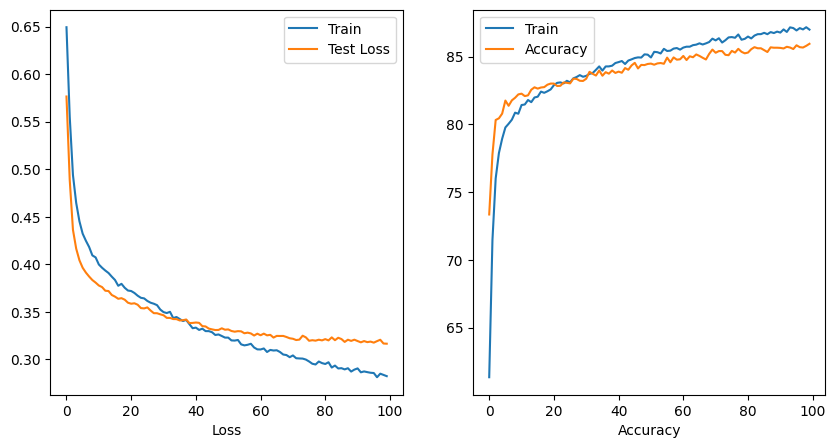

In [202]:
def plot_training_progress():
    plt.figure(figsize=(10, 5))
    for i, (key, data) in enumerate(progress.items()):
        plt.subplot(1, 2, i % 2 + 1)
        plt.plot(np.arange(len(data)), np.array(data), label="Train" if i // 2 == 0 else "Test" + " " + "Loss" if i % 2 == 0 else "Accuracy")
        plt.xlabel("Loss" if i % 2 == 0 else "Accuracy")
        plt.legend()
    
plot_training_progress()

## Evaluation

---

Overall, the model is decent, but probably not better than a XGBoost or LightGBM classifier. Its evaluation metrics using a decision threshold of 0.5 are as follows: 

1. Accuracy: 0.86
2. Precision: 0.79
3. Recall: 0.80
4. F1-score: 0.79

The decision threshold ought to be adjusted to suit the needs of the scenario and the neccesary precision/recall can be obtained from the precision recall curve.

In [203]:
model.eval()
predictions = None
actual_y = None
with torch.inference_mode():
    for X, cat, y in test_dl:
        pred = model(X, cat)
        if predictions is None:
            predictions = pred
            actual_y = y
        else:
            predictions = torch.cat([predictions, pred], axis=0)
            actual_y = torch.cat([actual_y, y], axis=0)
predictions = predictions.detach().cpu().numpy()
actual_y = actual_y.detach().cpu().numpy()
print(classification_report(actual_y, np.where(predictions >= 0.5, 1, 0)))

              precision    recall  f1-score   support

         0.0       0.89      0.91      0.90      4878
         1.0       0.80      0.76      0.78      2377

    accuracy                           0.86      7255
   macro avg       0.84      0.83      0.84      7255
weighted avg       0.86      0.86      0.86      7255



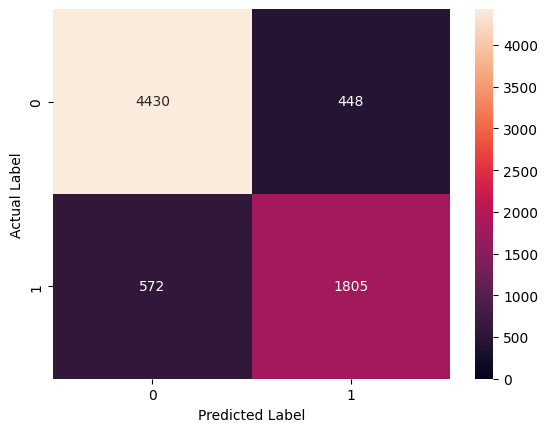

In [204]:
matrix = confusion_matrix(actual_y, np.where(predictions >= 0.5, 1, 0))
sb.heatmap(data=matrix, vmin=0, annot=True, fmt="")
plt.ylabel("Actual Label")
_ = plt.xlabel("Predicted Label")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


ROC AUC score: 0.9281245736310959


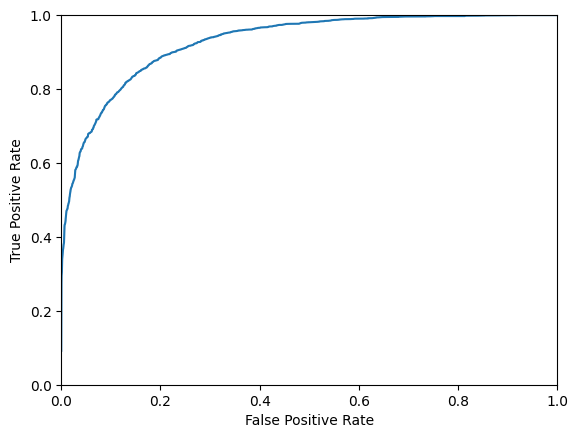

In [205]:
fpr, tpr, thres = roc_curve(actual_y, predictions)
sb.lineplot(x=fpr, y=tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.xlim((0,1))
plt.ylim((0,1))
roc_auc = roc_auc_score(actual_y, predictions)
print(f"ROC AUC score: {roc_auc}")

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


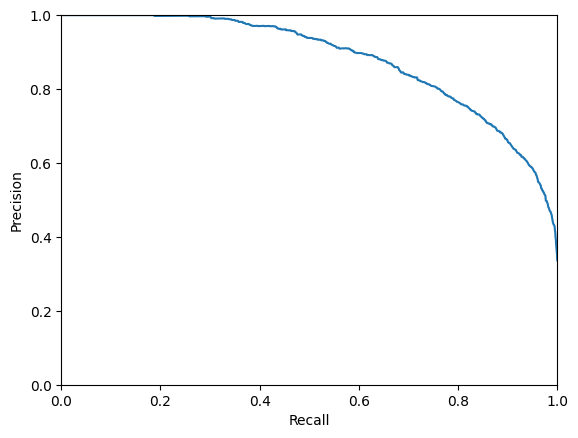

In [206]:
precision, recall, thres = precision_recall_curve(actual_y, predictions)
sb.lineplot(x=recall, y=precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.xlim((0,1))
_ = plt.ylim((0,1))

## Understanding

---

Based on the following graphs,

1. Lead time, average price per room and number of special requests appear to be the 3 most important factors in determining if a customer will cancel their reservations.
2. For lead time, the longer the lead time, the more likely the customer will cancel their reservation. This is understandable from the customer's perspective as they are likely to find better accomodations and cancellations with long lead times are likely to be free.
3. Similarly, with higher average price per room comes higher cancellation rates as well. Customers appear to be price sensitive in this aspect. Howover, an additional study would need to be done to determine if both market segments are price sensitive. 
4. Unsurprisingly, a higher number of special requests means the customer is more likely to follow through with their reservation. Finding accomodations that can handle special requests is difficult so customers are likely to stick with their booking.




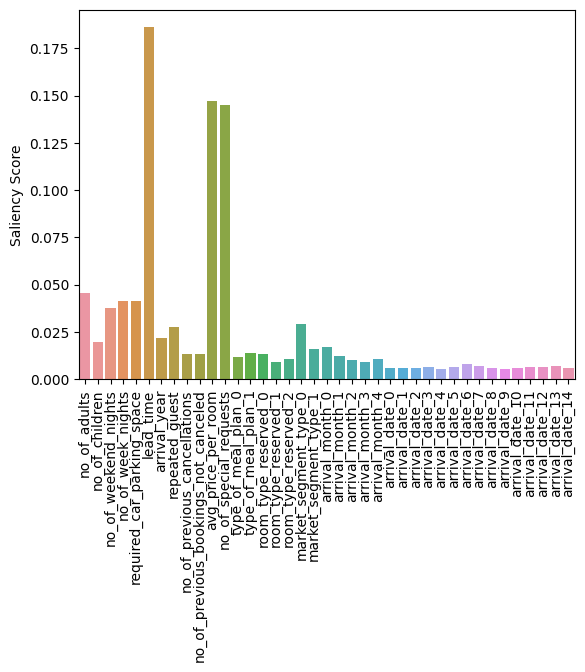

In [207]:
# saliency maps
model.train()
saliency = captum.attr.Saliency(model.model)
saliency_score = saliency.attribute(model.categorical_embedding(test_ds.X, test_ds.cat), target=0)
saliency_score = saliency_score.detach().cpu().numpy().astype(np.float64).sum(axis=0)
saliency_score = saliency_score / np.linalg.norm(saliency_score, ord=1)

labels = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
 'no_of_week_nights', 'required_car_parking_space',
 'lead_time', 'arrival_year', 'repeated_guest',
 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room', 'no_of_special_requests']
for embedding_size, col in zip(embedding_sizes, cat_cols):
    labels += [f"{col}_{i}" for i in range(embedding_size)] 

sb.barplot(x=np.array(labels), y=saliency_score)
plt.xticks(rotation=90)
_ = plt.ylabel("Saliency Score")

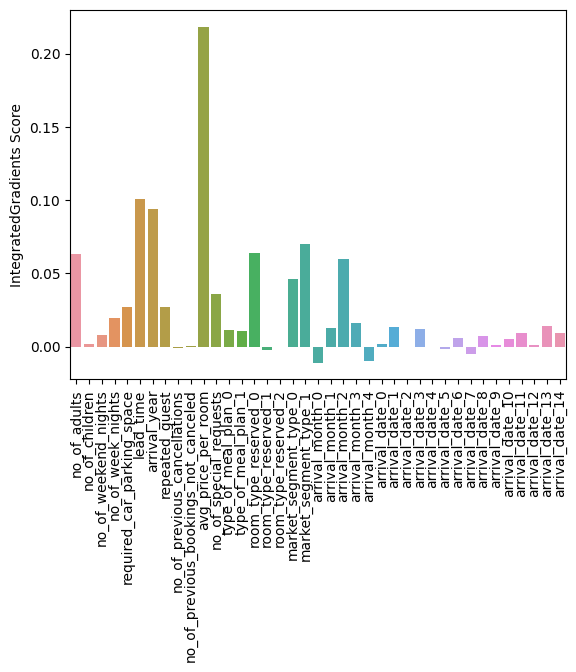

In [208]:
# Integrated Gradients
IG_score = np.zeros(39)
IG = captum.attr.IntegratedGradients(model.model)
for X, cat, y in test_dl:
    IG_round_score = IG.attribute(model.categorical_embedding(X, cat), target=0)
    IG_score += IG_round_score.detach().cpu().numpy().astype(np.float64).sum(axis=0)
IG_score = IG_score / np.linalg.norm(IG_score, ord=1)

labels = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
 'no_of_week_nights', 'required_car_parking_space',
 'lead_time', 'arrival_year', 'repeated_guest',
 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room', 'no_of_special_requests']
for embedding_size, col in zip(embedding_sizes, cat_cols):
    labels += [f"{col}_{i}" for i in range(embedding_size)] 

sb.barplot(x=np.array(labels), y=IG_score)
plt.xticks(rotation=90)
_ = plt.ylabel("IntegratedGradients Score")

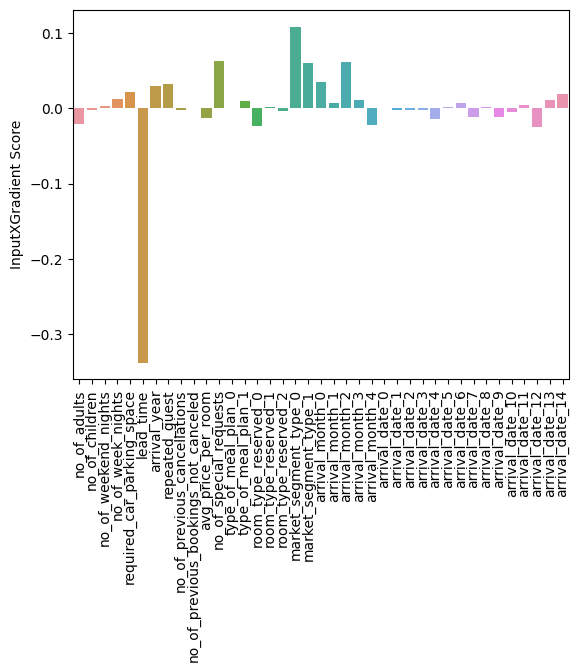

In [209]:
# Integrated Gradients
InputXGradient = captum.attr.InputXGradient(model.model)
InputXGradient_score = InputXGradient.attribute(model.categorical_embedding(test_ds.X, test_ds.cat), target=0, )
InputXGradient_score = InputXGradient_score.detach().cpu().numpy().astype(np.float64).sum(axis=0)
InputXGradient_score = InputXGradient_score / np.linalg.norm(InputXGradient_score, ord=1)

labels = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
 'no_of_week_nights', 'required_car_parking_space',
 'lead_time', 'arrival_year', 'repeated_guest',
 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room', 'no_of_special_requests']
for embedding_size, col in zip(embedding_sizes, cat_cols):
    labels += [f"{col}_{i}" for i in range(embedding_size)] 
    
sb.barplot(x=np.array(labels), y=InputXGradient_score)
plt.xticks(rotation=90)
_ = plt.ylabel("InputXGradient Score")

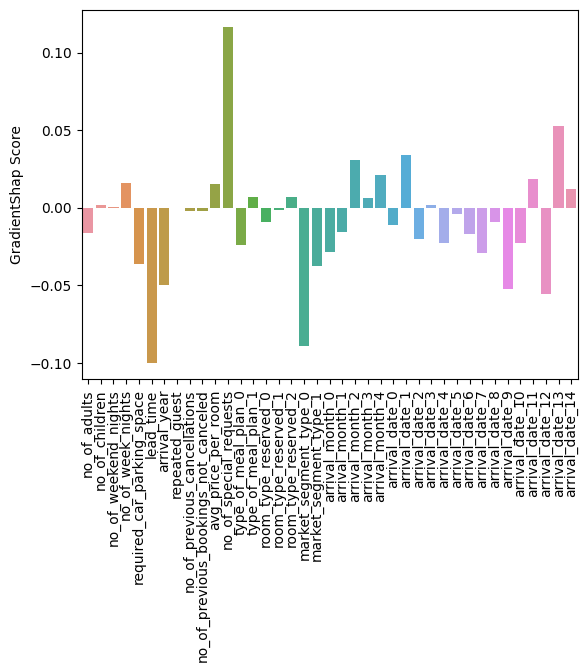

In [210]:
# Integrated Gradients
GradientShap = captum.attr.GradientShap(model.model)
GradientShap_score = GradientShap.attribute(model.categorical_embedding(test_ds.X, test_ds.cat), model.categorical_embedding(train_ds.X, train_ds.cat), target=0)
GradientShap_score = GradientShap_score.detach().cpu().numpy().astype(np.float64).sum(axis=0)
GradientShap_score = GradientShap_score / np.linalg.norm(GradientShap_score, ord=1)

labels = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
 'no_of_week_nights', 'required_car_parking_space',
 'lead_time', 'arrival_year', 'repeated_guest',
 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room', 'no_of_special_requests']
for embedding_size, col in zip(embedding_sizes, cat_cols):
    labels += [f"{col}_{i}" for i in range(embedding_size)]
    
sb.barplot(x=np.array(labels), y=GradientShap_score)
plt.xticks(rotation=90)
_ = plt.ylabel("GradientShap Score")

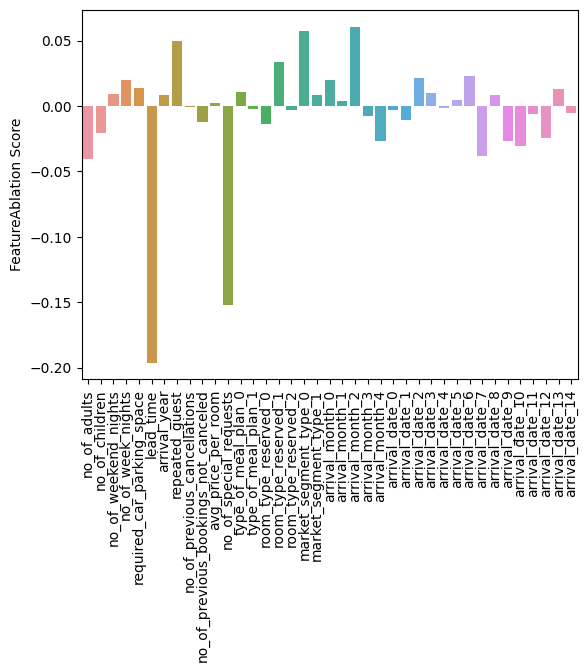

In [211]:
# Integrated Gradients
base_line = torch.zeros(1, 12), torch.zeros(1, 5, dtype=torch.int)
base_line = model.categorical_embedding(*base_line)
FeatureAblation = captum.attr.FeatureAblation(model.model)
FeatureAblation_score = FeatureAblation.attribute(model.categorical_embedding(test_ds.X, test_ds.cat), base_line, target=0)
FeatureAblation_score = FeatureAblation_score.detach().cpu().numpy().astype(np.float64).sum(axis=0)
FeatureAblation_score = FeatureAblation_score / np.linalg.norm(FeatureAblation_score, ord=1)

labels = ['no_of_adults', 'no_of_children', 'no_of_weekend_nights',
 'no_of_week_nights', 'required_car_parking_space',
 'lead_time', 'arrival_year', 'repeated_guest',
 'no_of_previous_cancellations', 'no_of_previous_bookings_not_canceled',
 'avg_price_per_room', 'no_of_special_requests']
for embedding_size, col in zip(embedding_sizes, cat_cols):
    labels += [f"{col}_{i}" for i in range(embedding_size)] 
    
sb.barplot(x=np.array(labels), y=FeatureAblation_score)
plt.xticks(rotation=90)
_ = plt.ylabel("FeatureAblation Score")

Interestingly, the market segment seems be to divided into 2 groups. The first group consists of: Online, Complementary and Offline while the other consists of Aviation and Corporate.

Otherwise, the other features appear evenly spread.

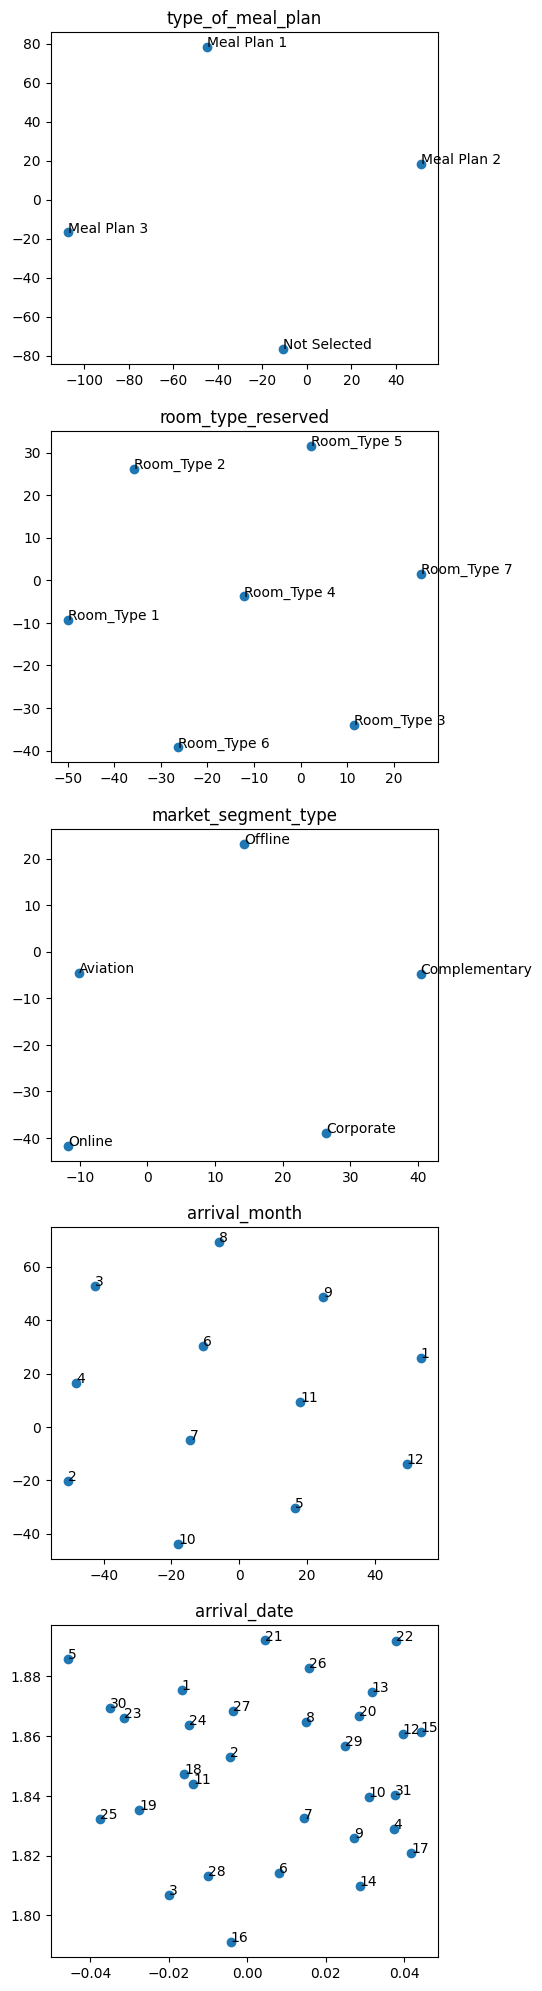

In [212]:
# inspecting embeddings
plt.figure(figsize=(5, 25))
label = ['type_of_meal_plan','room_type_reserved','market_segment_type','arrival_month','arrival_date']
for i, l in enumerate(label):
    weights = model.categorical_embedding.categorical_embedding[i].weight.detach().cpu().numpy()
    plt.subplot(5, 1, i + 1)
    weights = TSNE(perplexity=weights.shape[0] - 1).fit_transform(weights)
    plt.scatter(weights[:, 0], weights[:, 1])
    for txt, i in index_lookup[l].items():
        plt.annotate(txt, (weights[i, 0], weights[i, 1]))
    plt.title(l)
plt.show()

## Model Saving

---

In [213]:
torch.save(model.state_dict(), "model_state_dict.pth")